# Crowd Detection and Counting

In [2]:
import os
from ultralytics import YOLO
import supervision as sv
import numpy as np

In [3]:
# Choose your video path
CROWD_VIDEO_PATH = f"./data/Crowd_Activity.mp4"

# choose the model
model = YOLO('yolov8s.pt')

### Initial Detection

Ultralytics YOLOv8.0.35 🚀 Python-3.11.7 torch-2.2.0 CPU
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

0: 960x1280 14 persons, 2 skateboards, 1 vase, 398.9ms
Speed: 1.9ms pre-process, 398.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)


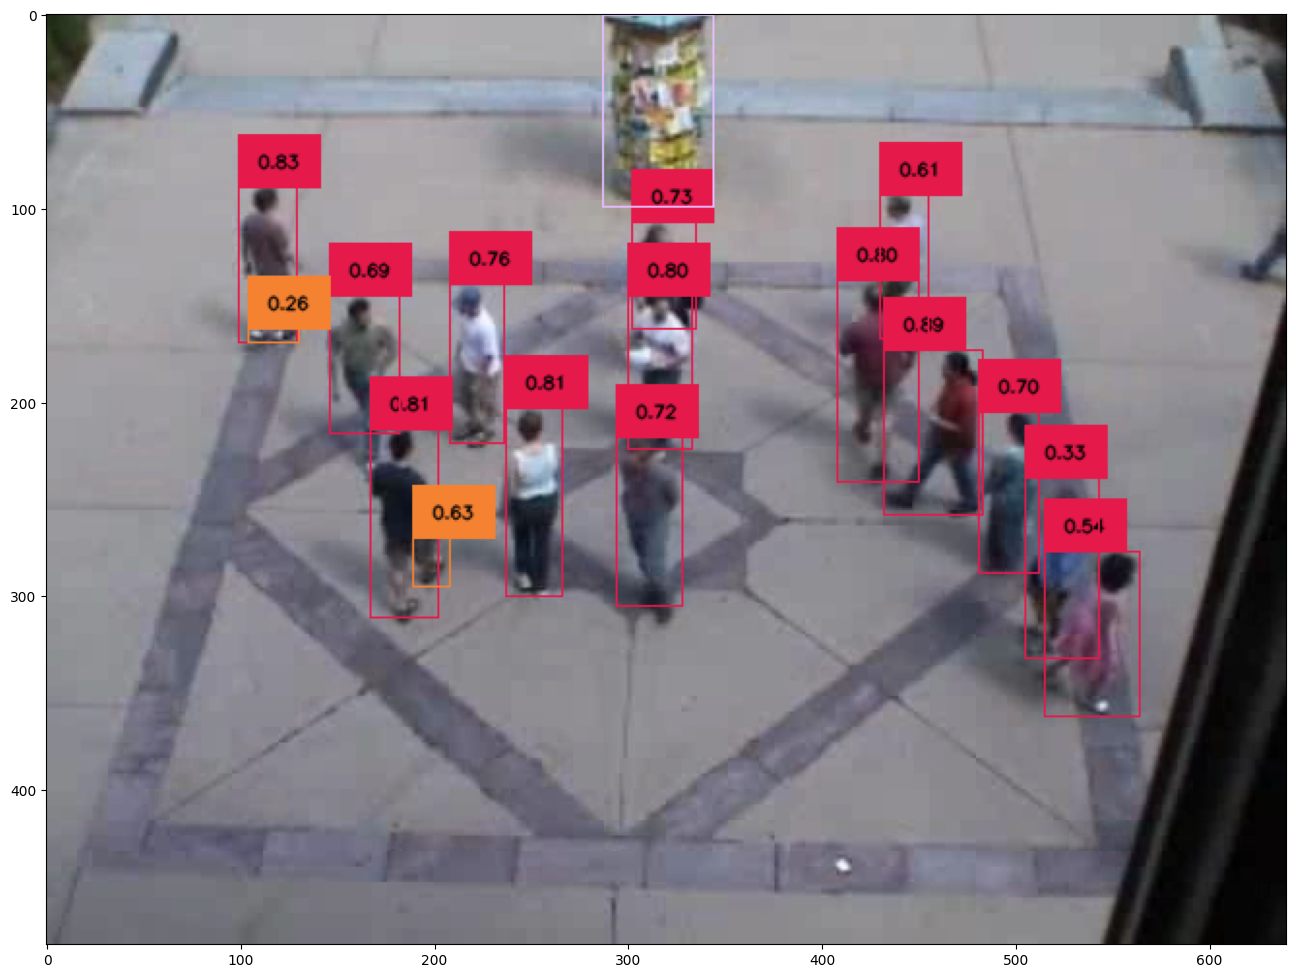

In [4]:
# extract video frame
generator = sv.get_video_frames_generator(CROWD_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.3)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

### Filtering
Since our goal is to detect only people, we will alter the code to filter our all other classes, We also add the class label here.


0: 960x1280 14 persons, 2 skateboards, 1 vase, 380.5ms
Speed: 1.0ms pre-process, 380.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


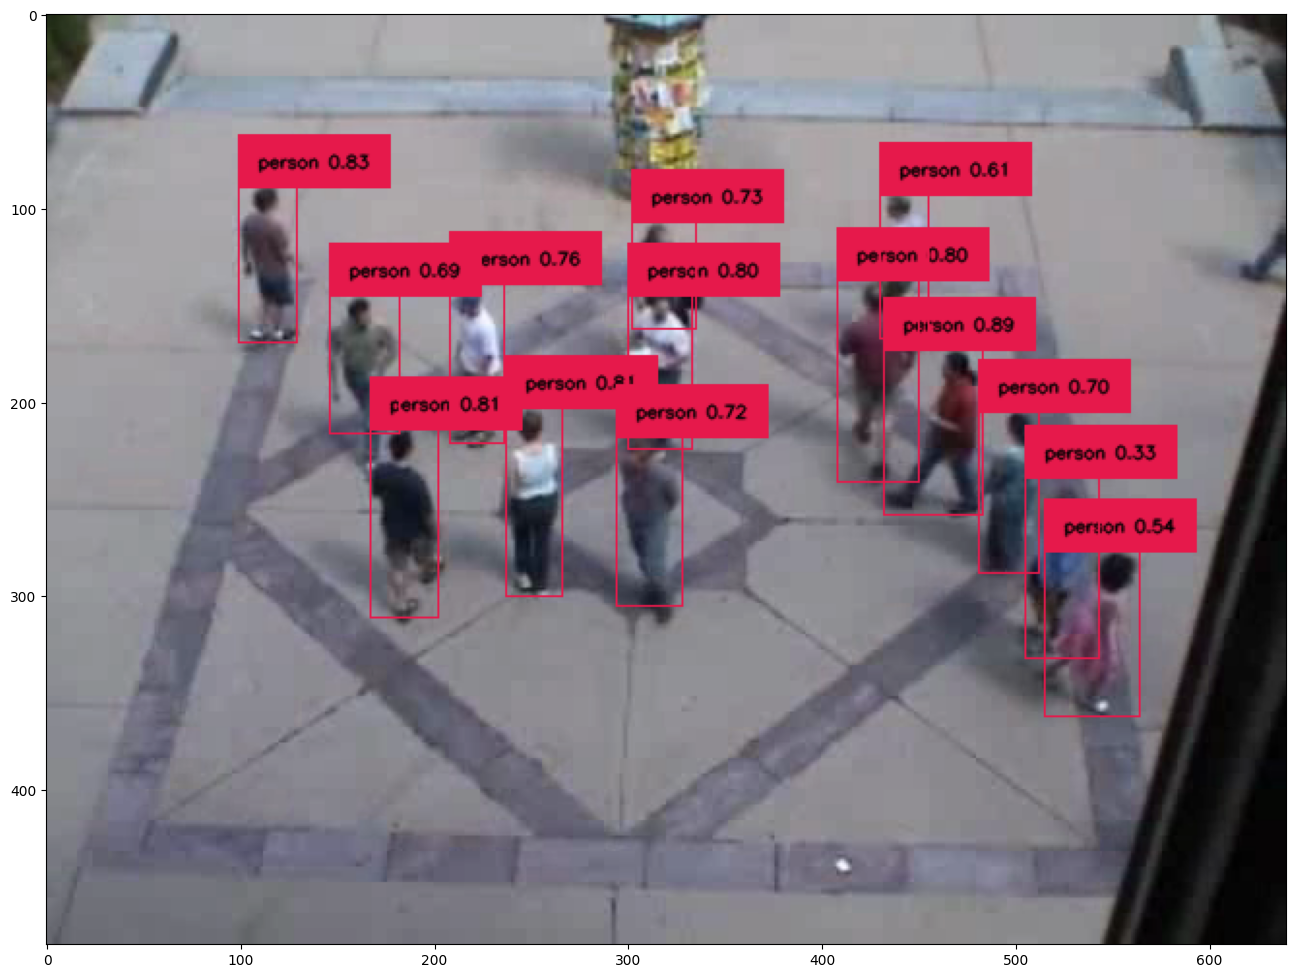

In [5]:
# extract video frame
generator = sv.get_video_frames_generator(CROWD_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[detections.class_id == 0]

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.3)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

### Polygon Zone
Now we can add a polygon zone to the scene and visualize it.

In [6]:
sv.VideoInfo.from_video_path(CROWD_VIDEO_PATH)

VideoInfo(width=640, height=480, fps=29, total_frames=769)


0: 960x1280 14 persons, 2 skateboards, 1 vase, 372.2ms
Speed: 1.3ms pre-process, 372.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


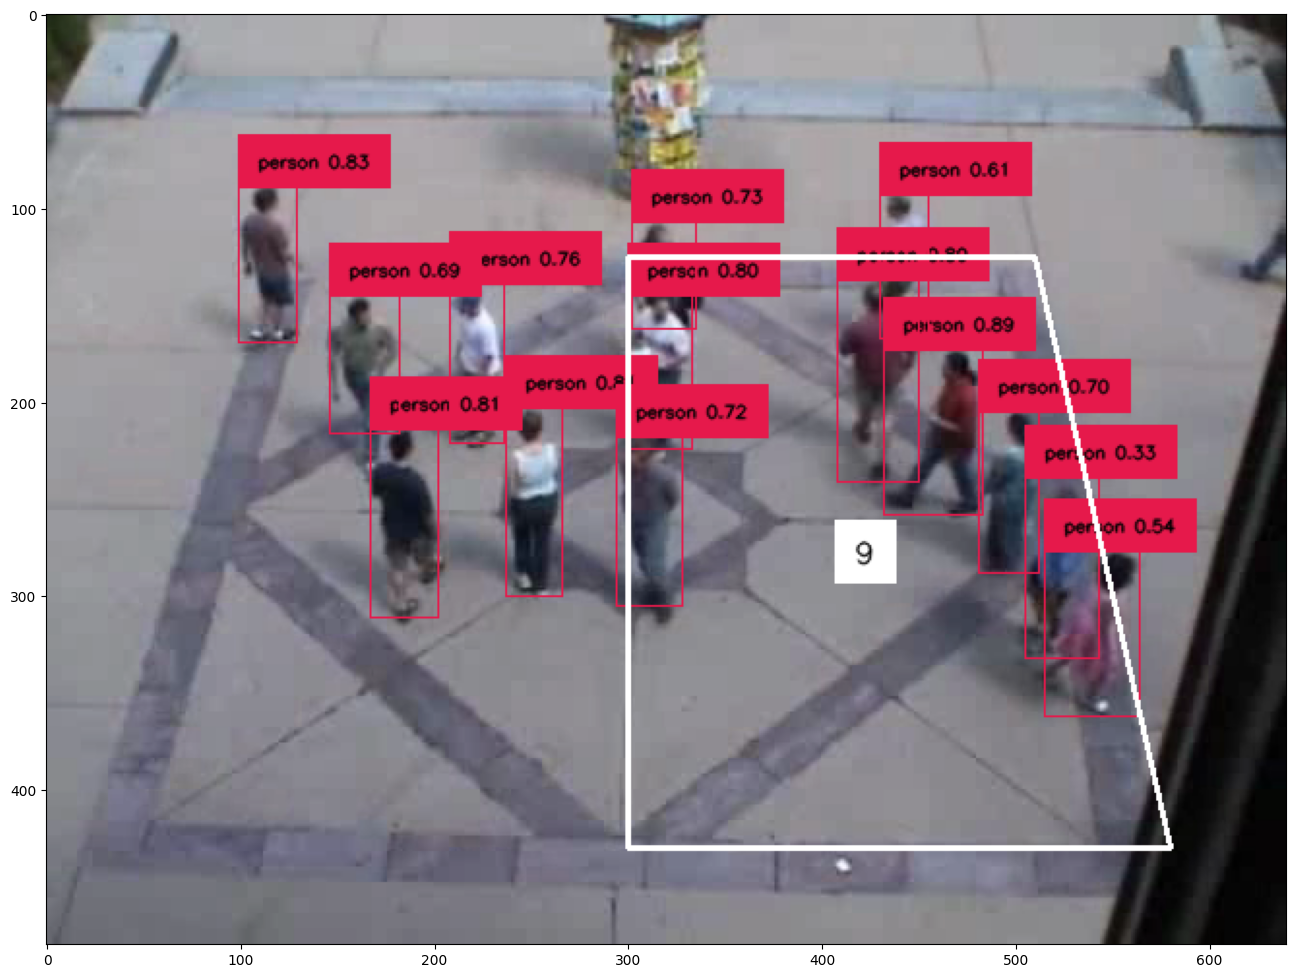

In [7]:
# initiate polygon zone
polygon = np.array([
    [300, 125],
    [510, 125],
    [580, 430],
    [300, 430]
])
video_info = sv.VideoInfo.from_video_path(CROWD_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.3)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=2, text_thickness=1, text_scale=0.5)

# extract video frame
generator = sv.get_video_frames_generator(CROWD_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

### Detect only in the Polygon zone


0: 960x1280 14 persons, 2 skateboards, 1 vase, 370.6ms
Speed: 1.3ms pre-process, 370.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)


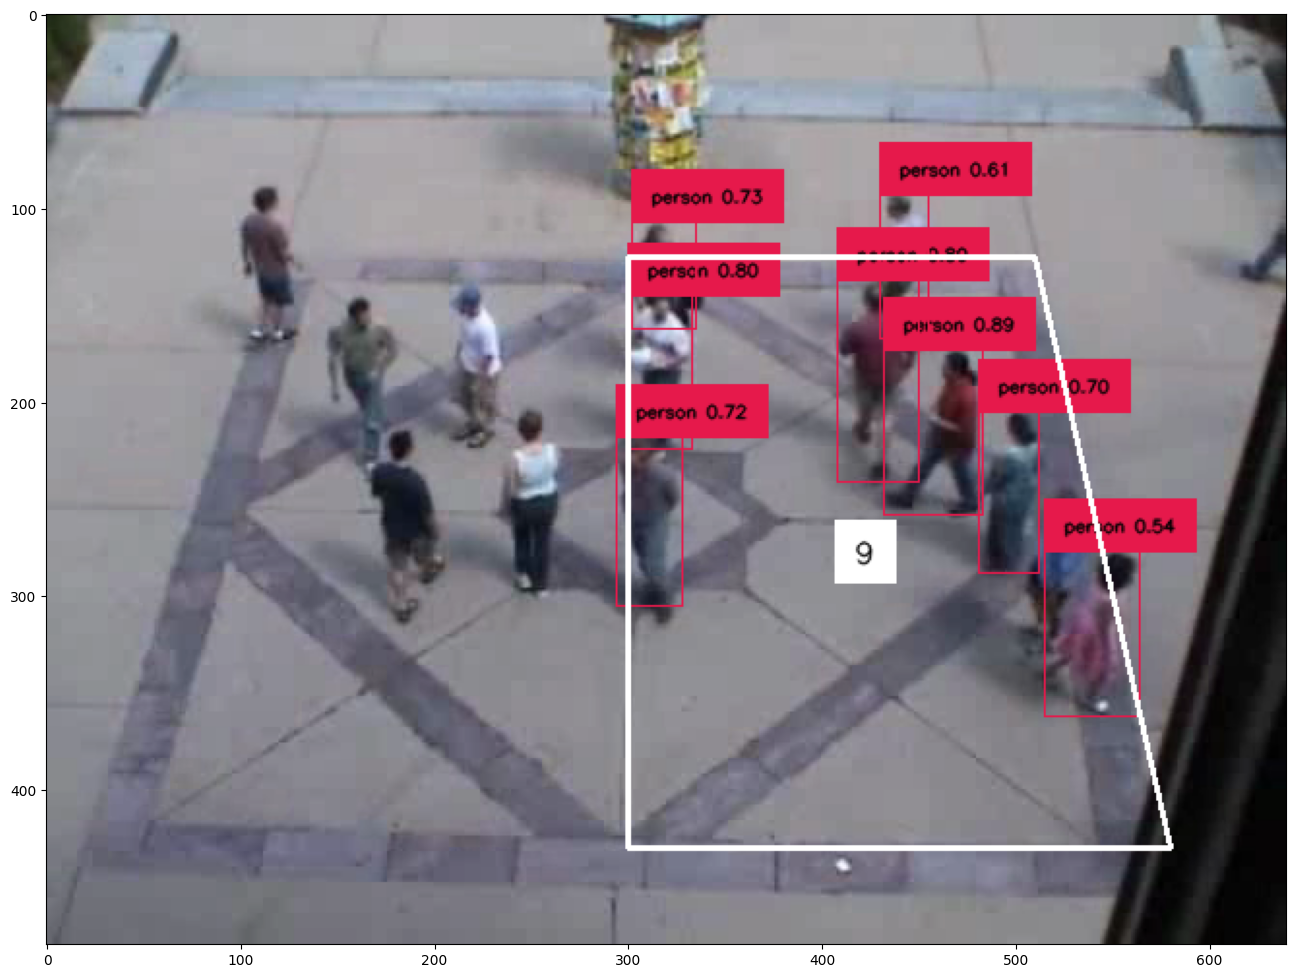

In [8]:
# extract video frame
generator = sv.get_video_frames_generator(CROWD_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
mask = zone.trigger(detections=detections)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5) & mask]

# annotate
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

### Multiple Polyzones


0: 960x1280 14 persons, 2 skateboards, 1 vase, 368.8ms
Speed: 1.1ms pre-process, 368.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)


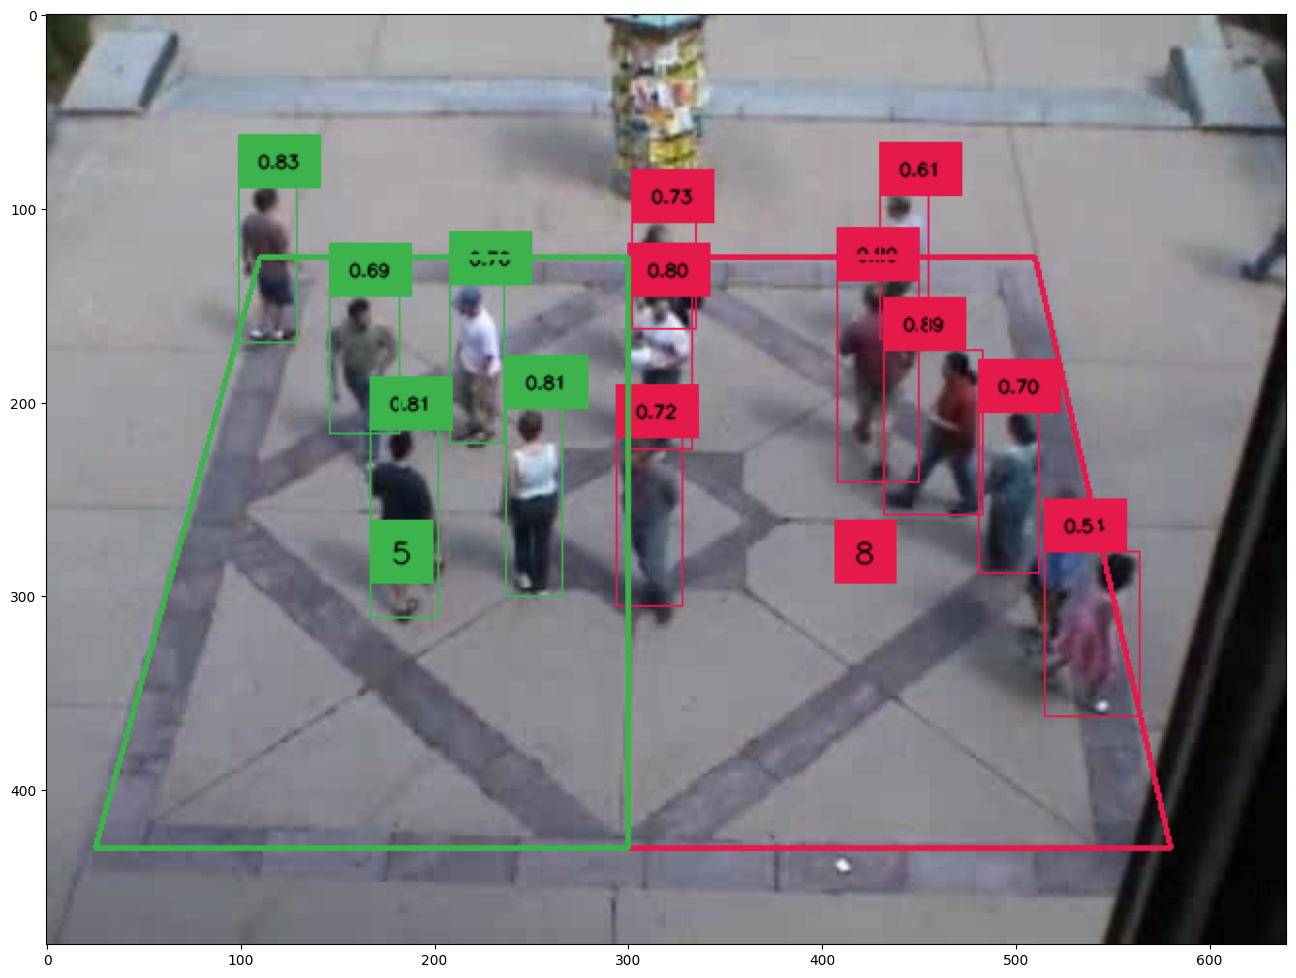

In [9]:
colors = sv.ColorPalette.default()
polygons = [
    np.array([
        [300, 125],
        [510, 125],
        [580, 430],
        [300, 430]
    ], np.int32),
    np.array([
        [110, 125],
        [300, 125],
        [300, 430],
        [25, 430]
    ], np.int32)
]
video_info = sv.VideoInfo.from_video_path(CROWD_VIDEO_PATH)

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=2,
        text_thickness=1,
        text_scale=0.5
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=1,
        text_thickness=1,
        text_scale=0.3
        )
    for index
    in range(len(polygons))
]

# extract video frame
generator = sv.get_video_frames_generator(CROWD_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5)]

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

### Processing the Whole Video

In [10]:
colors = sv.ColorPalette.default()
polygons = [
    np.array([
        [300, 125],
        [510, 125],
        [580, 430],
        [300, 430]
    ], np.int32),
    np.array([
        [110, 125],
        [300, 125],
        [300, 430],
        [25, 430]
    ], np.int32)
]
video_info = sv.VideoInfo.from_video_path(CROWD_VIDEO_PATH)

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=2,
        text_thickness=1,
        text_scale=0.5
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=1,
        text_thickness=1,
        text_scale=0.3
        )
    for index
    in range(len(polygons))
]

def process_frame(frame: np.ndarray, i) -> np.ndarray:
    print(i)
    # detect
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_yolov8(results)
    detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5)]

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=CROWD_VIDEO_PATH, target_path="./runs/crowd_result.mp4", callback=process_frame)

from IPython import display
display.clear_output()